In [1]:
# import sys
# !{sys.executable} -m pip install trulens
# !{sys.executable} -m pip install torchvision
# !{sys.executable} -m pip install matplotlib
# !{sys.executable} -m pip install wget
# !{sys.executable} -m pip install numpy --upgrade

In [2]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
import numpy as np

from trulens.nn.models import get_model_wrapper

import numpy as np
import matplotlib.pyplot as plt
import PIL

%matplotlib inline

In [3]:
# Tensorflow/Keras
from tensorflow.keras.applications.vgg16 import VGG16
from trulens.nn.models import get_model_wrapper
keras_model = VGG16(weights='imagenet')
# Produce a wrapped model from the keras model.
model = get_model_wrapper(keras_model)
# Pytorch
from torchvision.models import vgg16
from trulens.nn.models import get_model_wrapper
pytorch_model = vgg16(pretrained=True)
# Produce a wrapped model from the pytorch model.
model = get_model_wrapper(pytorch_model, input_shape=(3,224,224), device='cpu')

INFO: lib level=1
INFO: root level=30
INFO: Detected tensorflow backend for <class 'keras.engine.functional.Functional'>.
INFO: Changing backend from None to Backend.TENSORFLOW.
INFO: If this seems incorrect, you can force the correct backend by passing the `backend` parameter directly into your get_model_wrapper call.
C:\Users\seany\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\seany\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(m

In [4]:
# print(model)
print(dir(model))

# print(model.model)

['__abstractmethods__', '__call__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__slots__', '__str__', '__subclasshook__', '__weakref__', '_abc_impl', '_add_cut_name_and_anchor', '_extract_outputs_from_hooks', '_flatten', '_fprop', '_fprop_organize_vals', '_get_layer', '_get_model_layers', '_gives_logits', '_layernames', '_layers', '_logit_layer', '_model', '_nested_assign', '_qoi_bprop', '_tensors', '_to_tensor', '_unflatten', 'device', 'force_eval', 'fprop', 'logits', 'model', 'print_layer_names', 'probits', 'qoi_bprop']


In [23]:
string = model.print_layer_names.str()
print(string)

AttributeError: 'function' object has no attribute 'str'

In [6]:
import wget
wget.download("https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json")

100% [..............................................................................] 35363 / 35363

'imagenet_class_index (4).json'

C:\Users\seany\AppData\Local\Temp\ipykernel_24152\3931634293.py:11: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  x = np.array(img.resize((224,224), PIL.Image.ANTIALIAS))[np.newaxis]


(162, 'beagle', 18.69189)
(161, 'basset', 14.481131)
(238, 'Greater_Swiss_Mountain_dog', 14.465955)
(166, 'Walker_hound', 14.03977)
(167, 'English_foxhound', 13.260205)


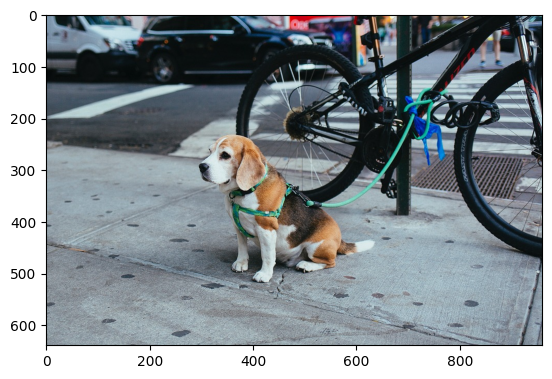

In [7]:
import json
import requests
import numpy as np

# Load the example record.
url = 'https://raw.githubusercontent.com/truera/trulens/master/notebooks/resources/dog_bike.jpg'
with PIL.Image.open(requests.get(url, stream=True).raw) as img:
    # View the image.
    plt.imshow(img)
    
    x = np.array(img.resize((224,224), PIL.Image.ANTIALIAS))[np.newaxis]
    
    # Normalize with https://pytorch.org/docs/stable/torchvision/models.html
    normalize = transforms.Compose([
        transforms.ToTensor(), # convert to [0, 1]
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225])])
    
    x_pp = np.array(normalize(x[0])).transpose(1, 2, 0)[np.newaxis]

    # Transpose to [*, C, H, W] for PyTorch convention.
    x = x.transpose(0, 3, 1, 2)
    x_pp = x_pp.transpose(0, 3, 1, 2)


# Pretty-print the model's top 5 predictions on this record.
with torch.no_grad():
    output = pytorch_model(torch.from_numpy(x_pp).to('cpu')).cpu().numpy()

with open('imagenet_class_index.json') as file:
    class_idx = json.load(file)
    
idx2label = [class_idx[str(k)][1] for k in range(len(class_idx))]
top_labels = [
    (idx, idx2label[idx], output[0][idx]) 
    for idx in np.argsort(output[0])[::-1][:5]]

print('\n'.join([str(label) for label in top_labels]))

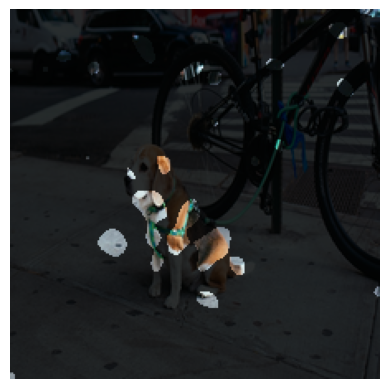

In [8]:
from trulens.nn.attribution import InputAttribution
from trulens.nn.attribution import IntegratedGradients
from trulens.visualizations import MaskVisualizer
from trulens.visualizations import HeatmapVisualizer

infl = InputAttribution(model)
attrs_input = infl.attributions(x_pp)

masked_image = MaskVisualizer(blur=5, threshold=0.95)(attrs_input, x)

In [9]:
from trulens.nn.attribution import InternalInfluence
from trulens.nn.distributions import PointDoi
from trulens.nn.quantities import ClassQoI, InternalChannelQoI, MaxClassQoI
from trulens.nn.slices import Cut, InputCut, OutputCut, Slice

# Define the influence measure.
infl = InternalInfluence(
    model, 
    Slice(Cut('features_28'), OutputCut()), 
    MaxClassQoI(),
    PointDoi())

# Get the attributions for the internal neurons at layer -10. Because layer -10
# contains 2D feature maps, we take the sum over the width and height of the 
# feature maps to obtain a single attribution for each feature map.
attrs_internal = infl.attributions(x_pp).sum(axis=(2,3))

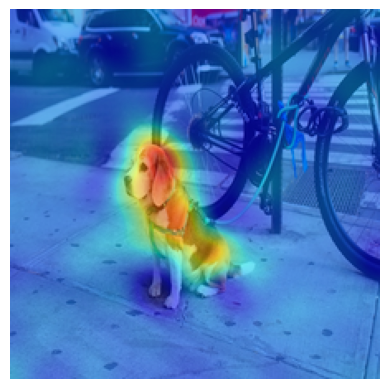

In [28]:
infl = IntegratedGradients(model, resolution=10)
attrs_input = infl.attributions(x_pp)
masked_image = HeatmapVisualizer(blur=10)(attrs_input, x)

In [11]:
from trulens.visualizations import ChannelMaskVisualizer

masked_image = ChannelMaskVisualizer(
    model,
    'features_28',
    top_feature_map,
    blur=10,
    threshold=0.95)(x, x_pp)

plt.axis('off')
plt.imshow(masked_image[0].transpose((1,2,0)))

# Define the influence measure.
infl_bike = InternalInfluence(model, 'features_28', 671, 'point')

# The above is shorthand for
#
# infl_bike = InternalInfluence(
#     model, 
#     Slice(Cut('features_28', OutputCut()),
#     ClassQoI(671), 
#     PointDoi())

# Get the attributions for each feature map.
attrs_bike_internal = infl_bike.attributions(x_pp).sum(axis=(2,3))

# Find the index of the top feature map.
top_feature_map_bike = int(attrs_bike_internal[0].argmax())

print('Top feature map:', top_feature_map_bike)

# Visualize the top feature map in the input space.
masked_image = ChannelMaskVisualizer(
    model,
    'features_28',
    top_feature_map_bike,
    blur=10, 
    threshold=0.95)(x, x_pp)

plt.axis('off')
plt.imshow(masked_image[0].transpose((1,2,0)))

NameError: name 'top_feature_map' is not defined